## Loading TinyStories and parsing vocab (first 10,000 stories)

In [82]:
import json
from tqdm import tqdm
import requests

OUTPUT_COUNTS = 'vocab_analysis/tinystories_counts.json'
OUTPUT_WORDS = 'vocab_analysis/tinystories_words.txt'
OUTPUT_TINYSTORIES = 'vocab_analysis/tinystories.txt'

def remove_punctuation(s):
    to_remove = "!\"#$%&()*+,-./:;<=>?@[\]^_`{|}"+'\u00e2\u20ac\u0153\u2122'
    for c in to_remove:
        if c in s:
            s = s.replace(c, " ")
    return " ".join(s.split())

tinystories_dataset_url = "https://datasets-server.huggingface.co/rows?dataset=roneneldan%2FTinyStories&config=default&split=train&"
word_counts = {}
stories = []

with open(OUTPUT_TINYSTORIES, "r") as f:
    for story in list(f.readlines()):
        stories.append(story)

if stories != []:
    for story in stories:
            for word in story.split():
                word = remove_punctuation(word.strip())
                if word in word_counts.keys(): word_counts[word] += 1
                else: 
                    if word == "" or word == " ": continue
                    word_counts[word] = 1
else:
    for i in range(100, 10100, 100):
        
        print("i", i)
        
        url = f'{tinystories_dataset_url}offset={i-100}'
        print(url)

        tinystories = requests.get(url).json()
        rows = tinystories["rows"]
        for row in tqdm(rows):
            story = row["row"]["text"].replace('\n', " ").replace("  ", " ")
            stories.append(story)
            for word in story.split():
                word = remove_punctuation(word.strip())
                if word in word_counts.keys(): word_counts[word] += 1
                else: 
                    if word == "" or word == " ": continue
                    word_counts[word] = 1
    
    with open(OUTPUT_TINYSTORIES, "w") as f:
        for story in stories:
            f.write(story+'\n')

with open(OUTPUT_COUNTS, "w") as f:
    json.dump(word_counts, f, indent = 6)

with open(OUTPUT_WORDS, "w") as f:
    for word in list(word_counts.keys()):
        f.write(word+'\n')
  
print(len(list(word_counts.keys())))

11493


## Re-load vocab into object

In [83]:
import json
from tqdm import tqdm

OUTPUT_COUNTS = 'vocab_analysis/tinystories_counts.json'
OUTPUT_WORDS = 'vocab_analysis/tinystories_words.txt'

with open(OUTPUT_COUNTS, "r") as f:
    word_counts_tinystories = json.load(f)
print("length of word_counts_tinystories:", len(word_counts_tinystories.keys()))


length of word_counts_tinystories: 11493


## Parse TinyToM vocab

*Using 1_FB (with free eval prompt)*

In [84]:
def remove_punctuation(s):
    to_remove = "!\"#$%&()*+,-./:;<=>?@[\]^_`{|}"+'\u00e2\u20ac\u0153\u2122'
    for c in to_remove:
        if c in s:
            s = s.replace(c, " ")
    return " ".join(s.split())

def get_word_counts(filename):
    word_counts = {}
    with open(filename, "r") as f:
        s = f.read().replace('\n', " ").replace("\'s", "")
        for word in list(s.split()):
            word = remove_punctuation(word.strip())
            if word in word_counts.keys(): word_counts[word] += 1
            elif word == "": continue
            else: word_counts[word] = 1
    return word_counts

TINYTOM_V1 = '../../data/conditions/tinytom-v1/1_forward_belief_false_belief/converted.txt'
word_counts_tinytom_v1 = get_word_counts(TINYTOM_V1)
print("length of word_counts_tinytom_v1:", len(word_counts_tinytom_v1.keys()))
with open(f'vocab_analysis/counts_tinytom_v1.json', "w") as f:
    json.dump(word_counts_tinytom_v1, f, indent=6)
                    
TINYTOM_V2 = '../../data/conditions/tinytom/1_forward_belief_false_belief/converted.txt'
word_counts_tinytom_v2 = get_word_counts(TINYTOM_V2)
print("length of word_counts_tinytom_v2:", len(word_counts_tinytom_v2.keys()))
with open(f'vocab_analysis/counts_tinytom_v2.json', "w") as f:
    json.dump(word_counts_tinytom_v2, f, indent=6)

TINYTOM_V3 = '../../data/conditions/tinytom-v3/1_forward_belief_false_belief/converted.txt'
word_counts_tinytom_v3 = get_word_counts(TINYTOM_V3)
print("length of word_counts_tinytom_v3:", len(word_counts_tinytom_v3.keys()))
with open(f'vocab_analysis/counts_tinytom_v3.json', "w") as f:
    json.dump(word_counts_tinytom_v3, f, indent=6)

length of word_counts_tinytom_v1: 2589
length of word_counts_tinytom_v2: 3253
length of word_counts_tinytom_v3: 792


## Get Names

In [125]:
names = []
with open('../../data/conditions/tinytom-v1/1_forward_belief_false_belief/stories_trimmed.csv', "r") as f:
    stories = list(f.readlines())
    for story in stories:
        names.append(story.split()[0])
with open('../../data/conditions/tinytom/1_forward_belief_false_belief/stories_trimmed.csv', "r") as f:
    stories = list(f.readlines())
    for story in stories:
        names.append(story.split()[0])
with open('../../data/conditions/tinytom-v3/1_forward_belief_false_belief/stories_trimmed.csv', "r") as f:
    stories = list(f.readlines())
    for story in stories:
        names.append(story.split()[0])

names = list(set(names))

with open('vocab_analysis/names.txt', "w") as f:
    for name in names:
        f.write(name)
        f.write('\n')


## Parse words that are in tinytom but not in tinystories


In [86]:
def load_names():
    names = []
    with open("vocab_analysis/names.txt", "r") as f:
        for line in list(f.readlines()):
            names.append(line.strip())
    return names

def in_x_not_tinystories(dataset, var, file, not_name=False, names=[]):
    if not_name:
        in_x_not_tinystories = [word for word in var.keys() if word not in word_counts_tinystories.keys() and word not in names]
        print(f"In {dataset} but not in TinyStories (and not a name):", len(in_x_not_tinystories))
    else:
        in_x_not_tinystories = [word for word in var.keys() if word not in word_counts_tinystories.keys()]
        print(f"In {dataset} but not in TinyStories:", len(in_x_not_tinystories))
    with open(file, "w") as f: 
        for word in in_x_not_tinystories: f.write(word+'\n')
    return in_x_not_tinystories

in_tinytom_v1_not_tinystories = in_x_not_tinystories("tinytom-v1", word_counts_tinytom_v1, "vocab_analysis/in_v1_not_tinystories.txt")
in_tinytom_v2_not_tinystories = in_x_not_tinystories("tinytom-v2", word_counts_tinytom_v2, "vocab_analysis/in_v2_not_tinystories.txt")
in_tinytom_v3_not_tinystories = in_x_not_tinystories("tinytom-v3", word_counts_tinytom_v3, "vocab_analysis/in_v3_not_tinystories.txt")

names = load_names()

in_tinytom_v1_not_tinystories_no_names = in_x_not_tinystories("tinytom-v1", word_counts_tinytom_v1, "vocab_analysis/in_v1_not_tinystories_no_names.txt", True, names)
in_tinytom_v2_not_tinystories_no_names = in_x_not_tinystories("tinytom-v2", word_counts_tinytom_v2, "vocab_analysis/in_v2_not_tinystories_no_names.txt", True, names)
in_tinytom_v3_not_tinystories_no_names = in_x_not_tinystories("tinytom-v3", word_counts_tinytom_v3, "vocab_analysis/in_v3_not_tinystories_no_names.txt", True, names)


In tinytom-v1 but not in TinyStories: 289
In tinytom-v2 but not in TinyStories: 497
In tinytom-v3 but not in TinyStories: 51
In tinytom-v1 but not in TinyStories (and not a name): 239
In tinytom-v2 but not in TinyStories (and not a name): 403
In tinytom-v3 but not in TinyStories (and not a name): 36


In [128]:
%pip install venny4py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.


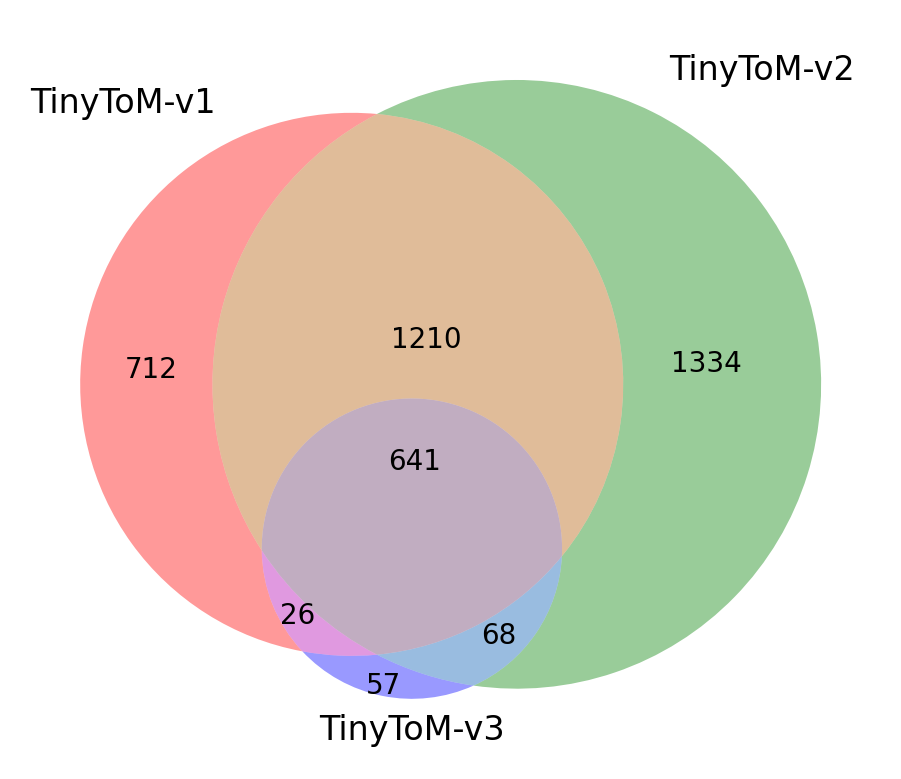

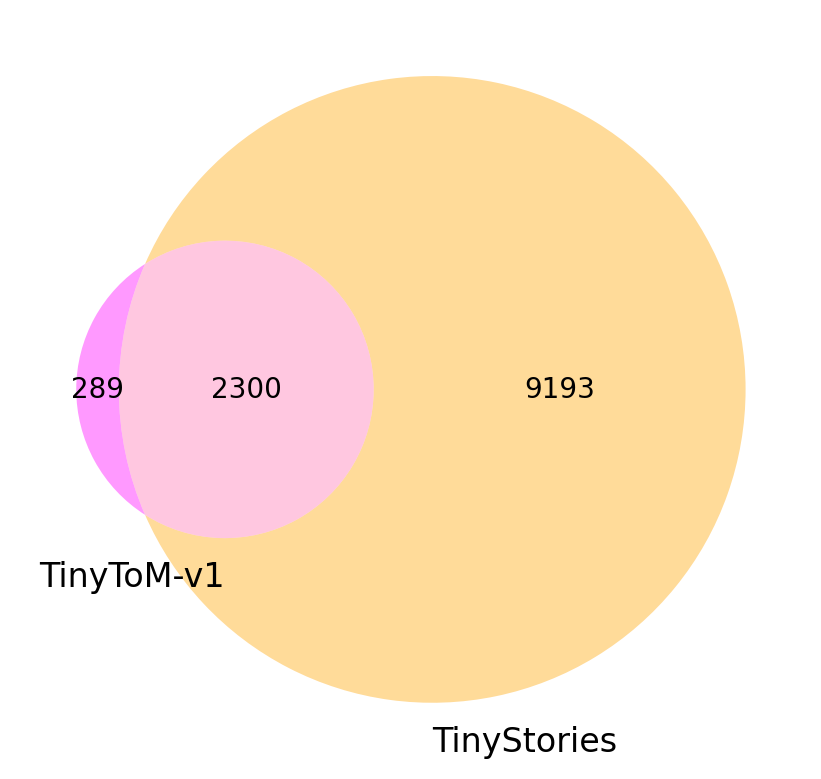

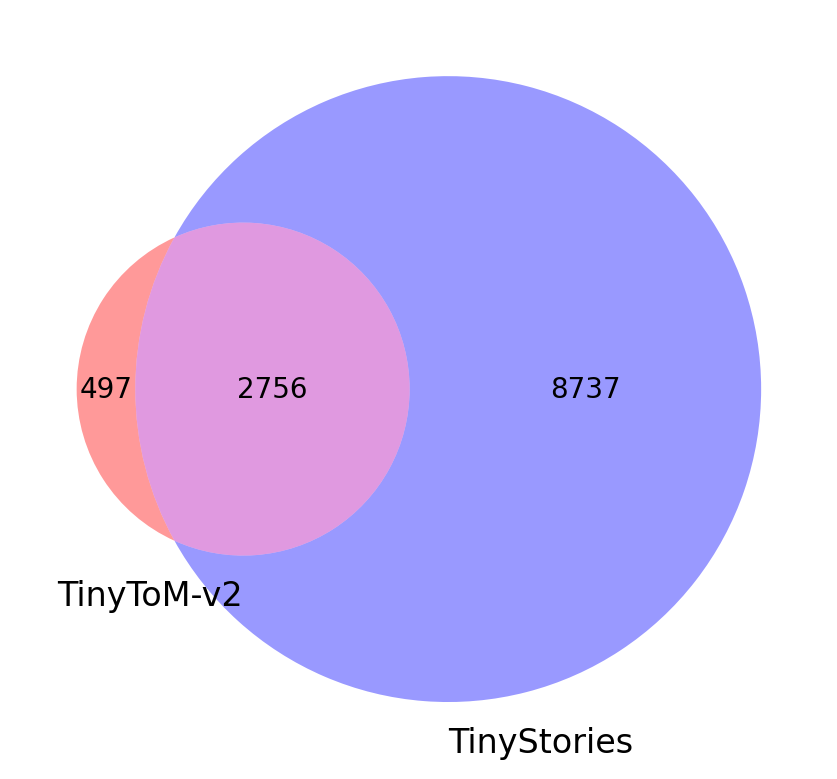

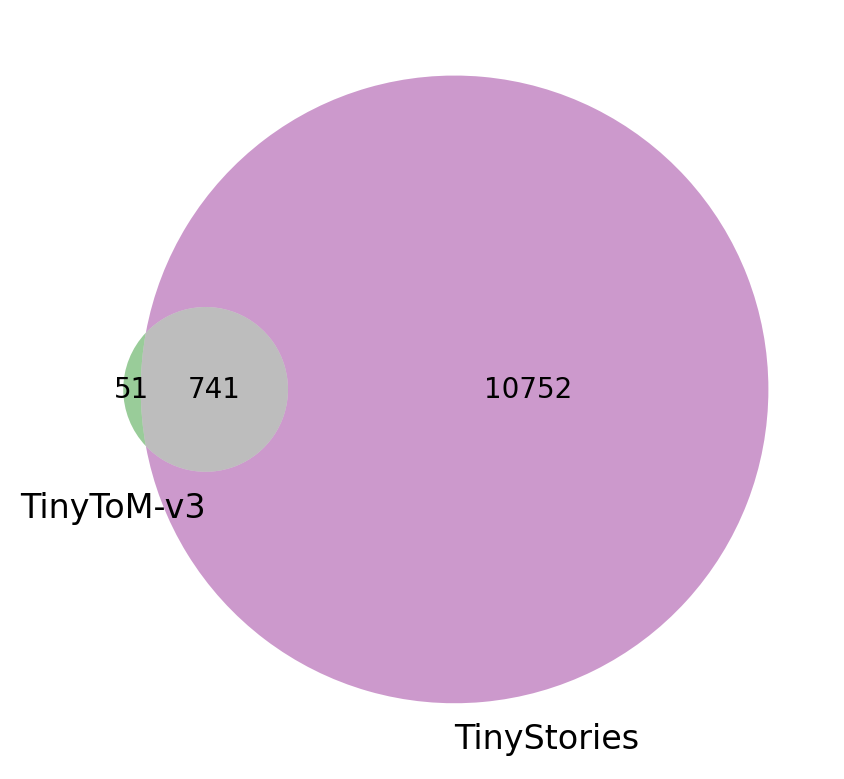

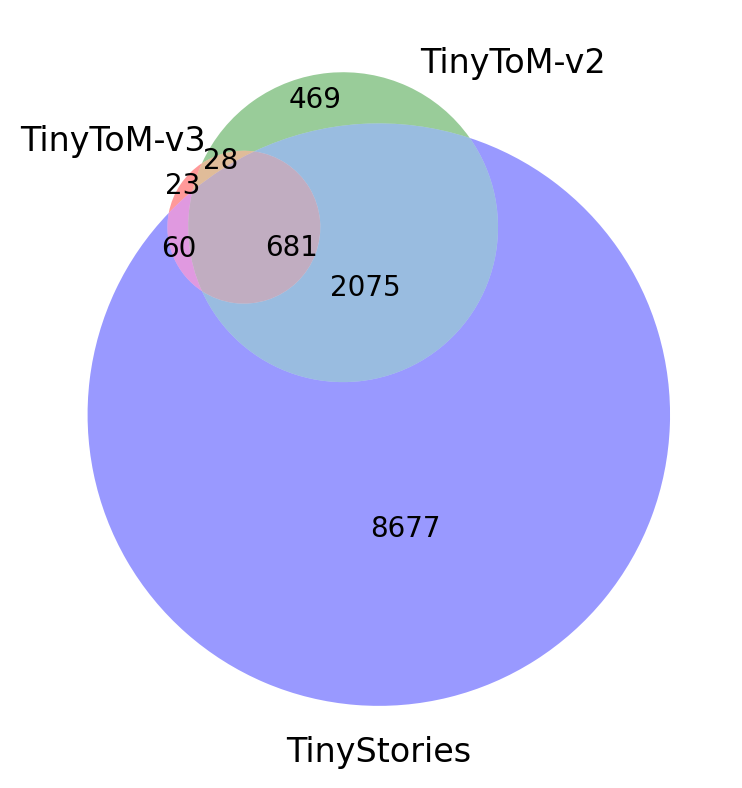

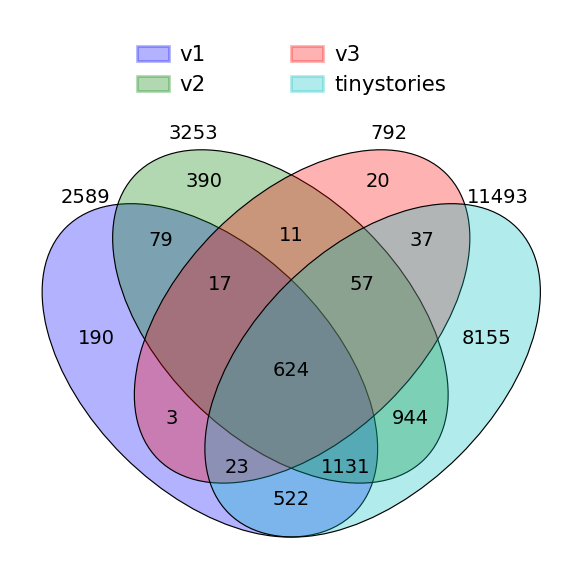

In [87]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2

from venny4py.venny4py import *

v1 = set(word_counts_tinytom_v1.keys())
v2 = set(word_counts_tinytom_v2.keys())
v3 = set(word_counts_tinytom_v3.keys())
tiny = set((word_counts_tinystories.keys()))

venn3([v1, v2, v3], ('TinyToM-v1', 'TinyToM-v2', 'TinyToM-v3'))
plt.show()

venn2([v1, tiny], ('TinyToM-v1', 'TinyStories'), set_colors=("magenta", "orange"))
plt.show()

venn2([v2, tiny], ('TinyToM-v2', 'TinyStories'), set_colors=("red", "blue"))
plt.show()

venn2([v3, tiny], ('TinyToM-v3', 'TinyStories'), set_colors=("green", "purple"))
plt.show()

venn3([v3, v2, tiny], ('TinyToM-v3', 'TinyToM-v2', 'TinyStories'))
plt.show()

#dict of sets
sets = {
    'v1': v1,
    'v2': v2,
    'v3': v3,
    'tinystories': tiny
}
    
venny4py(sets=sets)
plt.show()


## Mentalistic Verbs Distribution

In [88]:
tinystories_len = sum(list(word_counts_tinystories.values()))
v1_len = sum(list(word_counts_tinytom_v1.values()))
v2_len = sum(list(word_counts_tinytom_v2.values()))
v3_len = sum(list(word_counts_tinytom_v3.values()))

print("tinystories_len", tinystories_len)
print("v1_len", v1_len)
print("v2_len", v2_len)
print("v3_len", v3_len)

tinystories_len 1690162
v1_len 49412
v2_len 65309
v3_len 4560


[('want', 0.3344797936371453), ('feel', 0.13020513450436064), ('remember', 0.03402530401670557), ('know', 0.20378331900257954), ('think', 0.056381279941039184), ('believe', 0.03574499447242353), ('understand', 0.040904065839577446), ('recognize', 0.003685050976538509), ('wish', 0.026900872128731115), ('forget', 0.024689841542808007), ('learn', 0.05896081562461614), ('hope', 0.018179584817589977), ('decide', 0.010563812799410393), ('notice', 0.007738607050730868), ('imagine', 0.0060189165950128975), ('guess', 0.0063874216926667485), ('expect', 0.00135118535806412)]
[('notice', 0.21604938271604937), ('perceive', 0.030864197530864196), ('feel', 0.2962962962962963), ('guess', 0.05555555555555555), ('wish', 0.32098765432098764), ('learn', 0.043209876543209874), ('want', 0.024691358024691357), ('know', 0.012345679012345678)]
[('wish', 0.1797752808988764), ('feel', 0.3258426966292135), ('learn', 0.03932584269662921), ('notice', 0.3202247191011236), ('guess', 0.016853932584269662), ('want', 0.

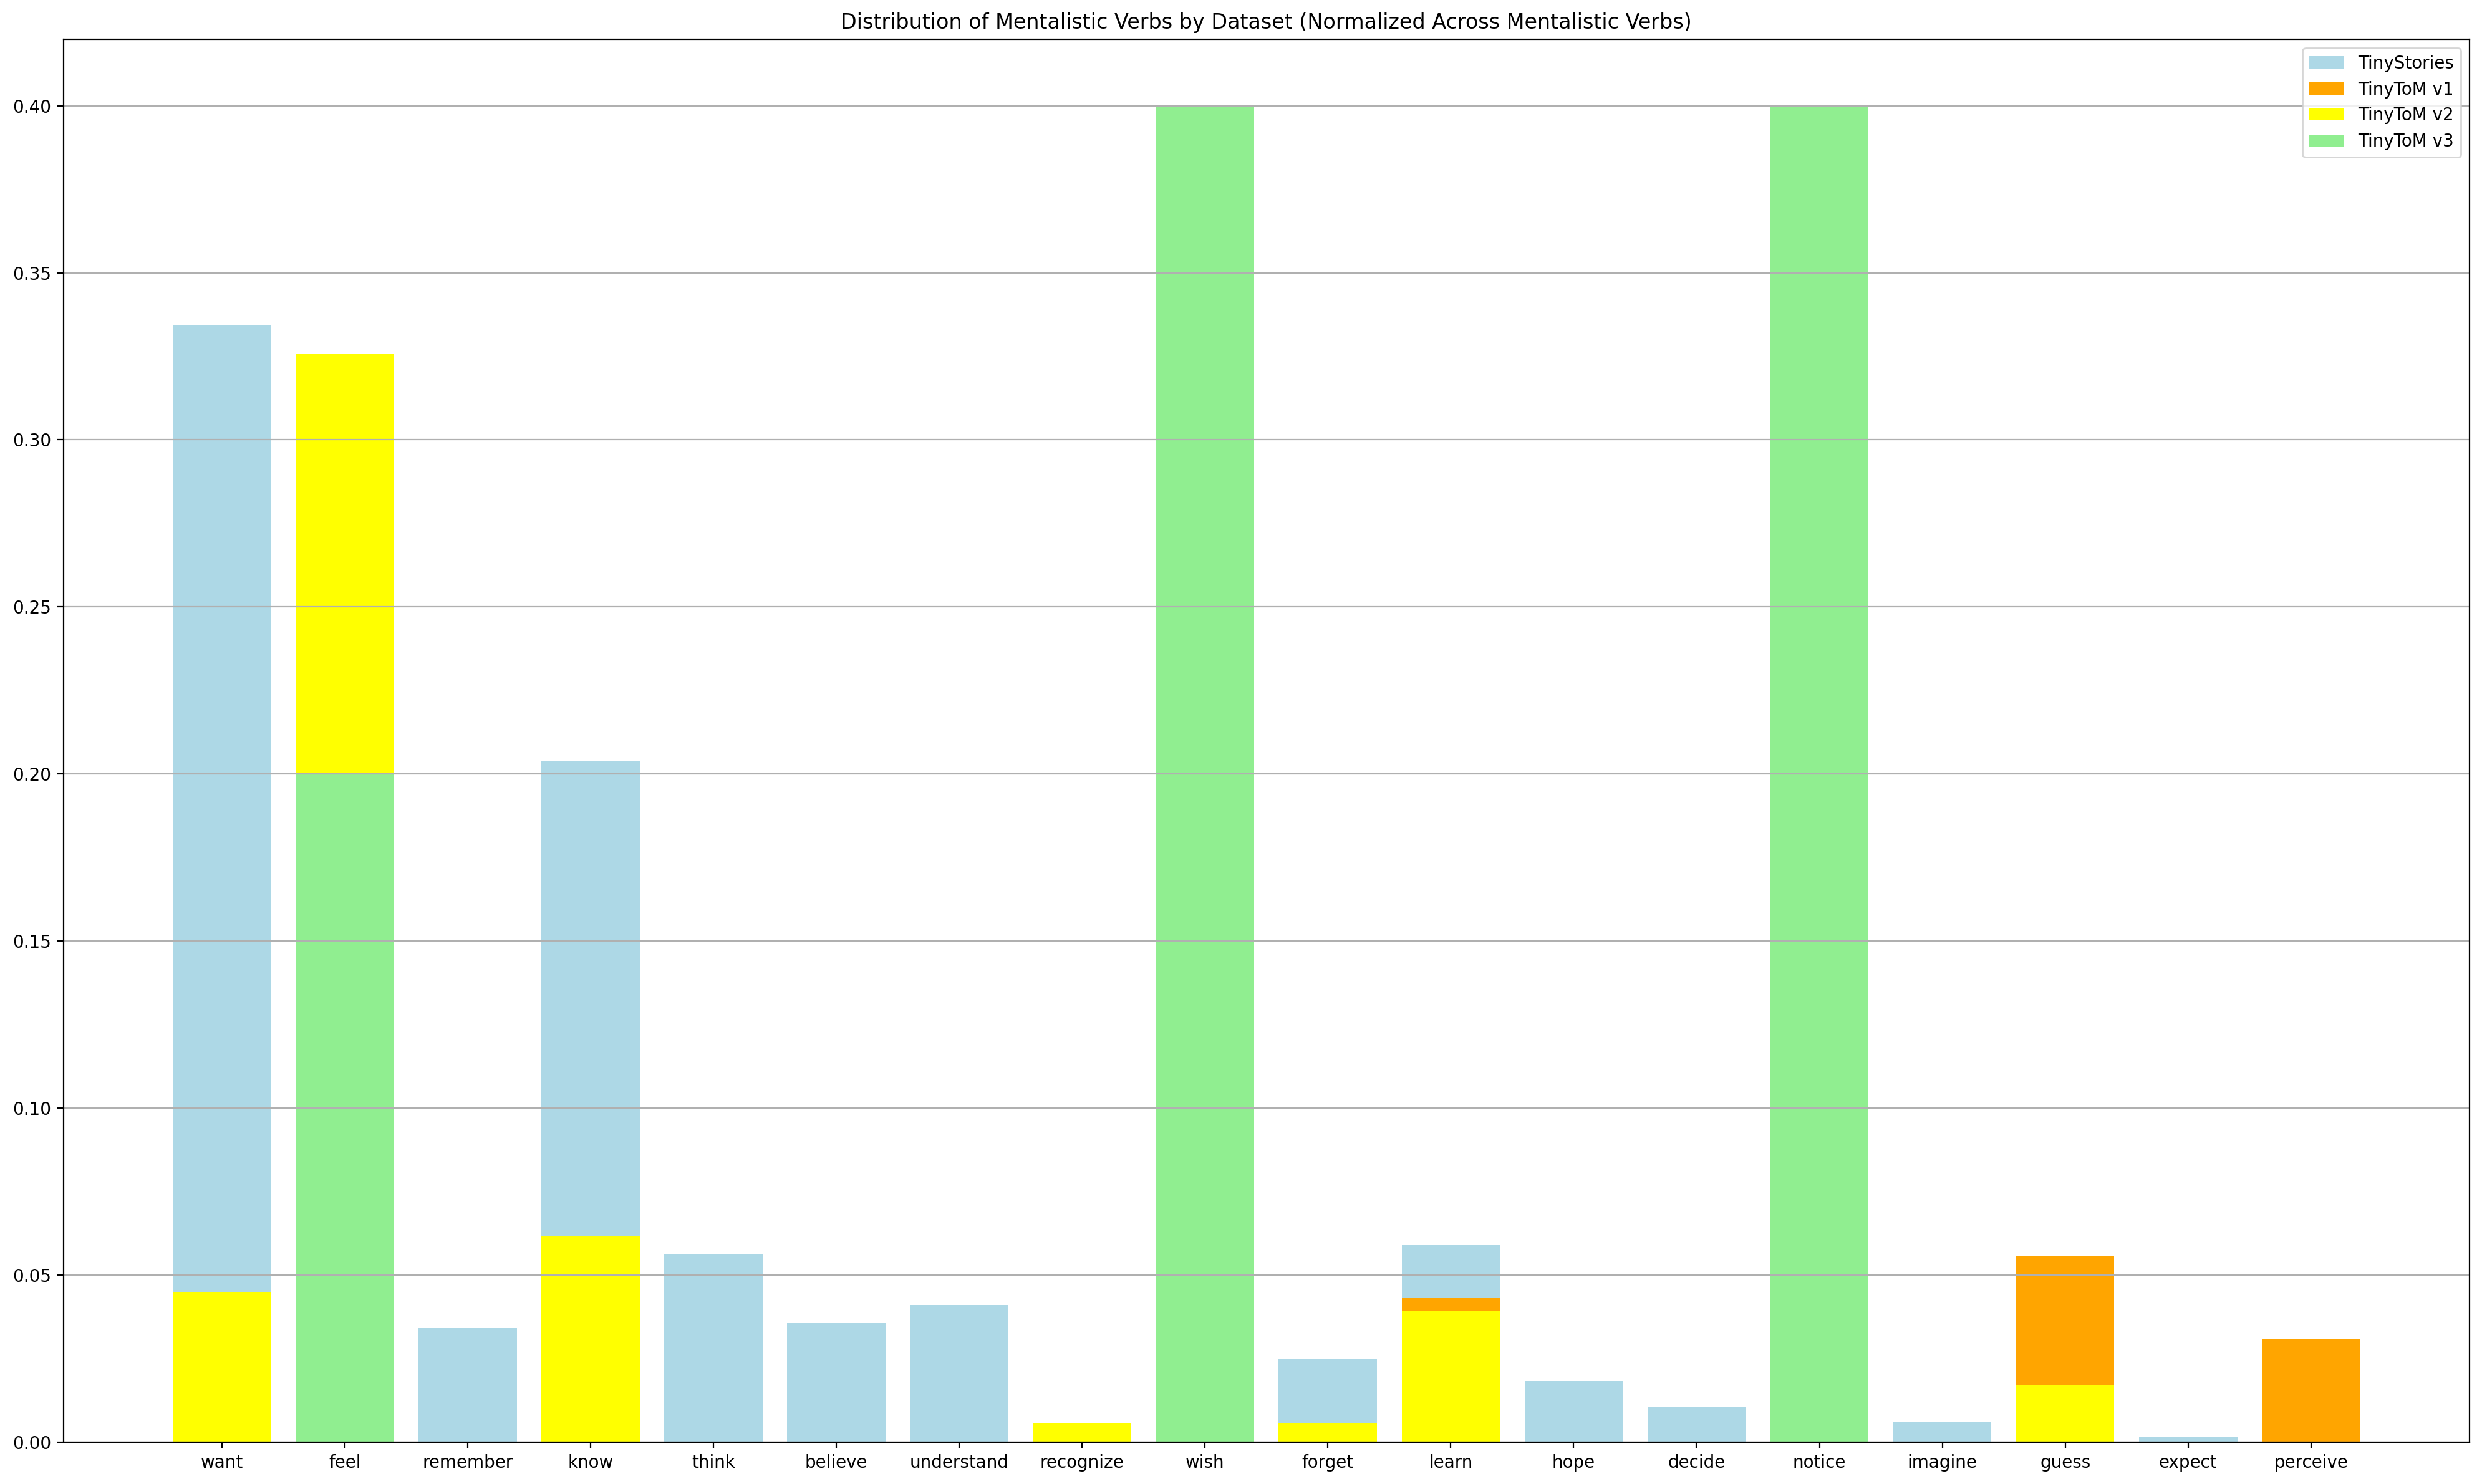

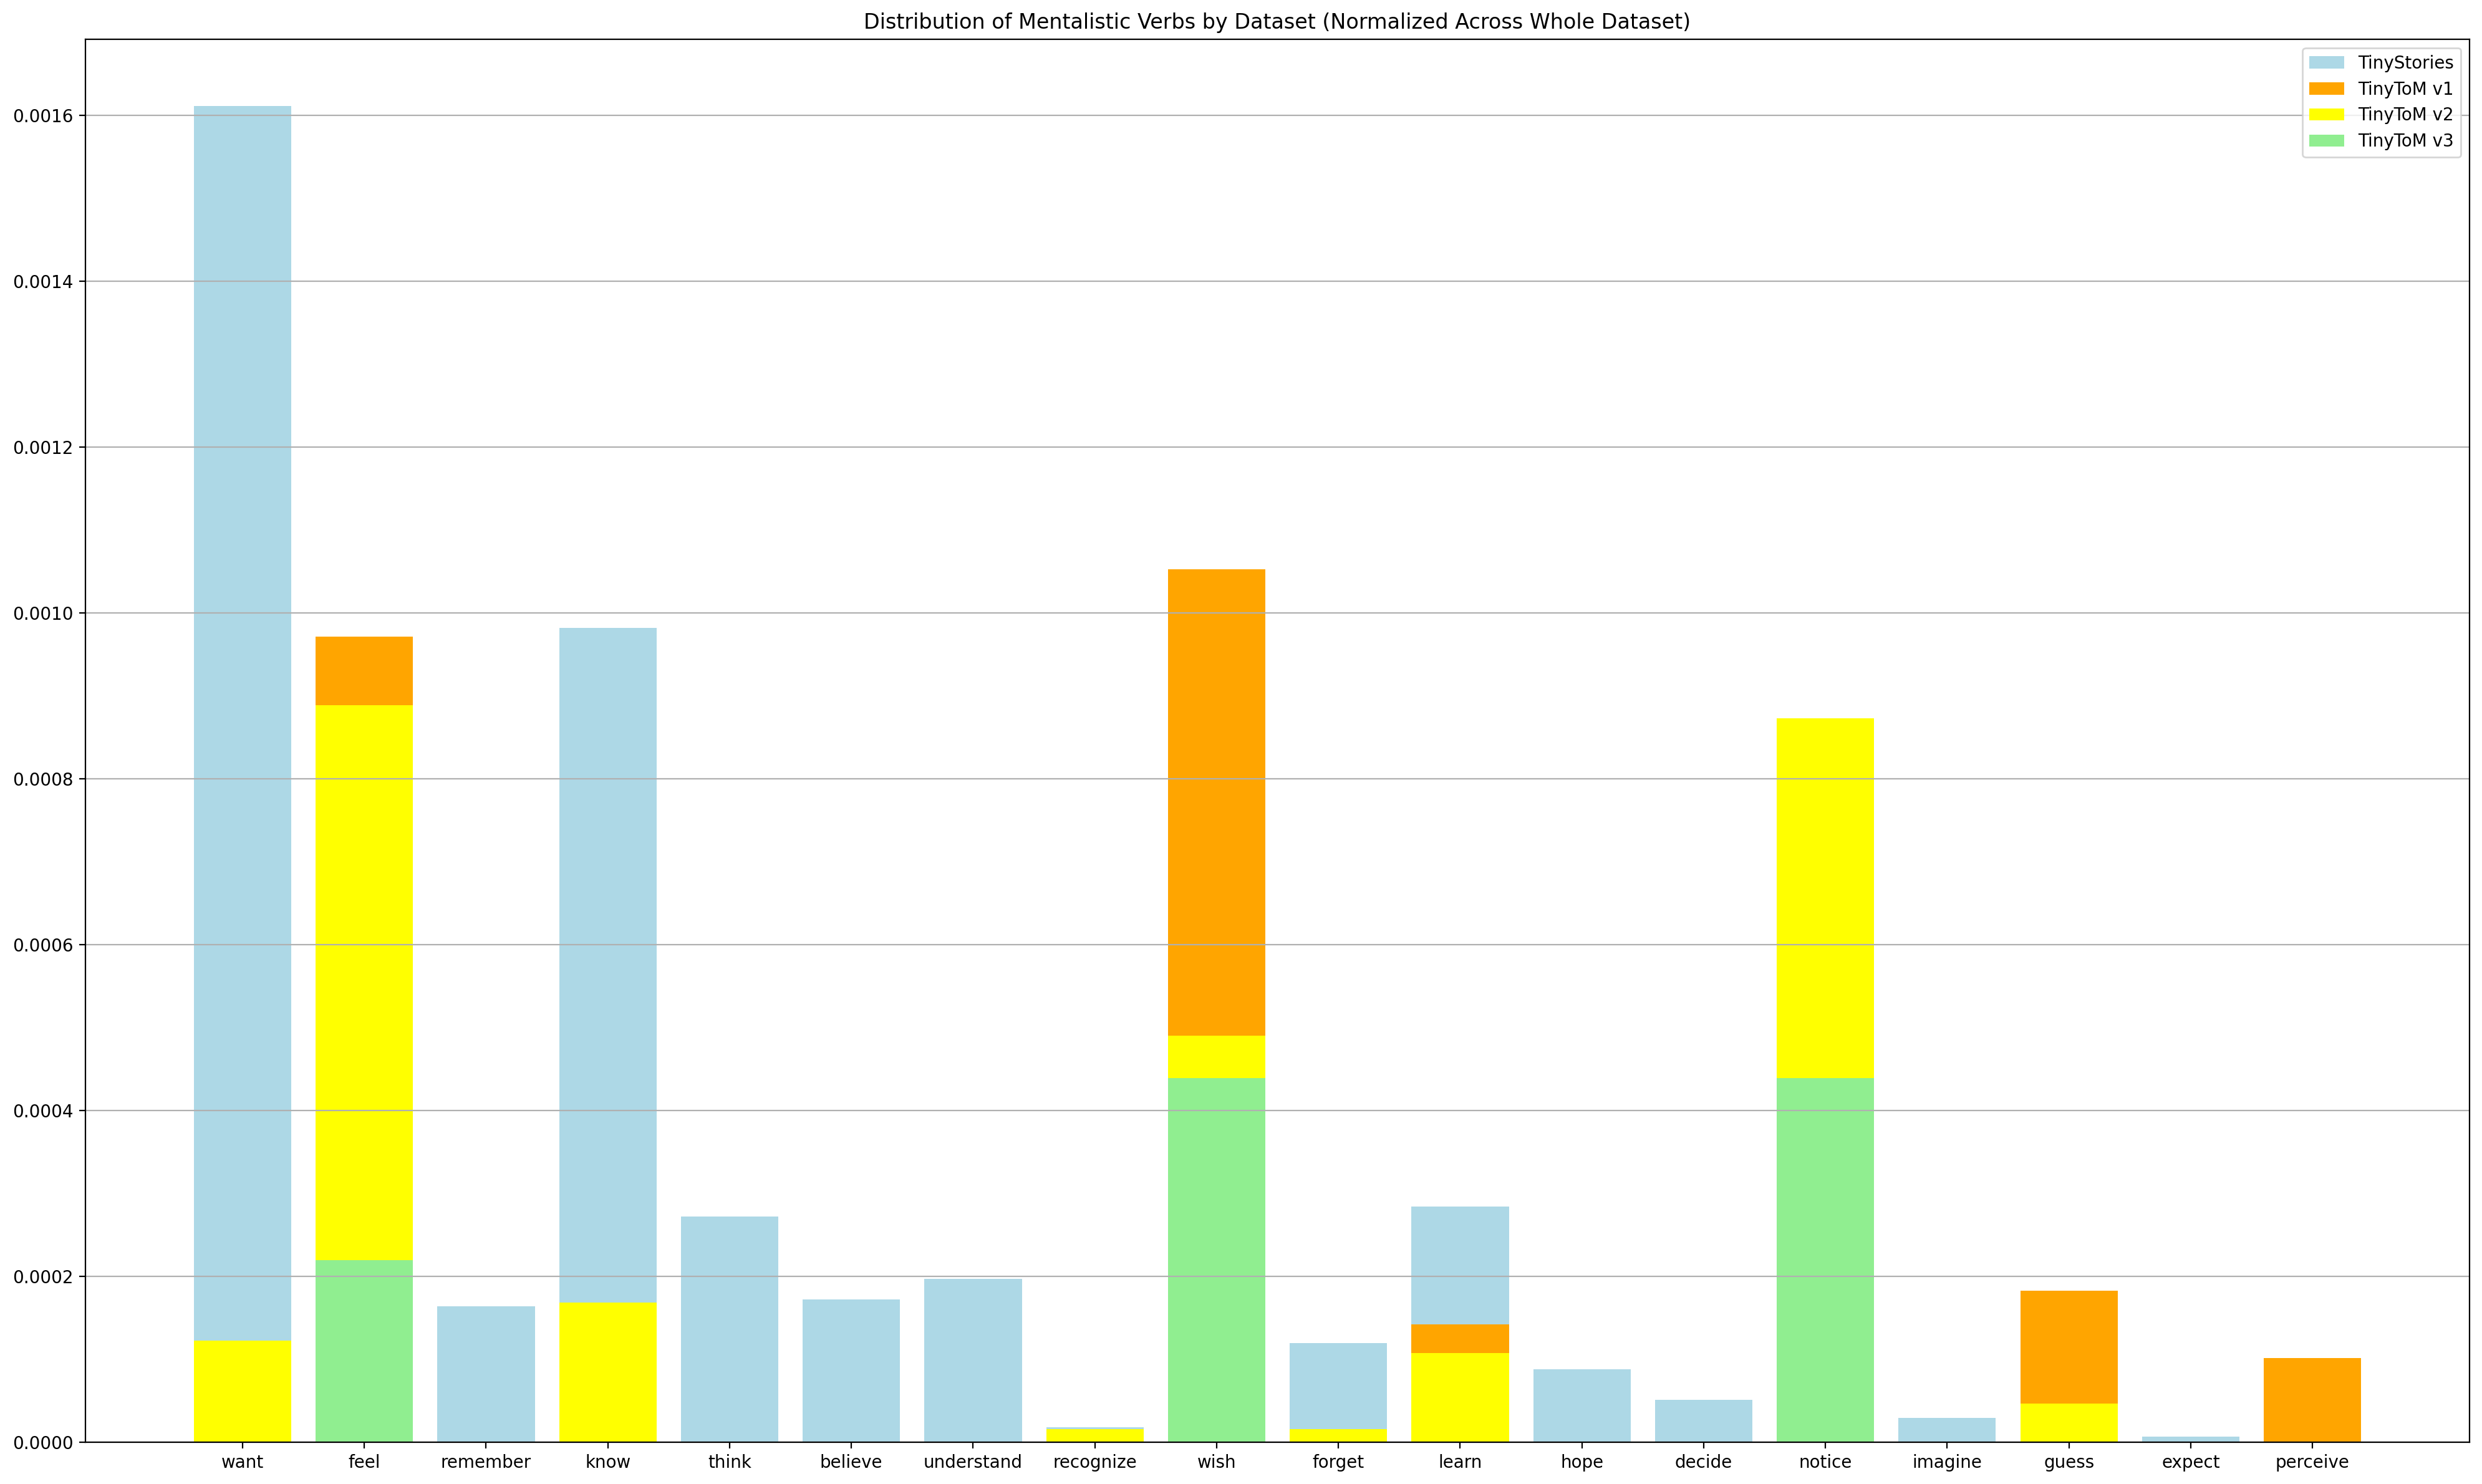

In [89]:
beliefs_keywords = ["know", "think", "learn", "understand", "perceive", "believe", "forget", "guess", "notice", "recognize"]
emotion_keywords = ["feel"]
desire_keywords = ["want", "wish", "hope", "decide", "prefer"]
others_keywords = ["imagine", "expect", "remember"]
all = beliefs_keywords + emotion_keywords + desire_keywords + others_keywords

mental_verbs_tinystories = [pair for pair in word_counts_tinystories.items() if pair[0] in all]
mental_total_tinystories = sum([x[1] for x in mental_verbs_tinystories])
mental_verbs_tinystories_normalized = [(pair[0], pair[1]/mental_total_tinystories) for pair in mental_verbs_tinystories]
print(mental_verbs_tinystories_normalized)

mental_verbs_tinytom_v1 = [pair for pair in word_counts_tinytom_v1.items() if pair[0] in all]
mental_total_tinytom_v1 = sum([x[1] for x in mental_verbs_tinytom_v1])
mental_verbs_tinytom_v1_normalized = [(pair[0], pair[1]/mental_total_tinytom_v1) for pair in mental_verbs_tinytom_v1]
print(mental_verbs_tinytom_v1_normalized)

mental_verbs_tinytom_v2 = [pair for pair in word_counts_tinytom_v2.items() if pair[0] in all]
mental_total_tinytom_v2 = sum([x[1] for x in mental_verbs_tinytom_v2])
mental_verbs_tinytom_v2_normalized = [(pair[0], pair[1]/mental_total_tinytom_v2) for pair in mental_verbs_tinytom_v2]
print(mental_verbs_tinytom_v2_normalized)

mental_verbs_tinytom_v3 = [pair for pair in word_counts_tinytom_v3.items() if pair[0] in all]
mental_total_tinytom_v3 = sum([x[1] for x in mental_verbs_tinytom_v3])
mental_verbs_tinytom_v3_normalized = [(pair[0], pair[1]/mental_total_tinytom_v3) for pair in mental_verbs_tinytom_v3]
print(mental_verbs_tinytom_v3_normalized)

# Create the bar plot
fig, ax = plt.subplots(figsize=(20,12))
ax.bar([x[0] for x in mental_verbs_tinystories_normalized], [x[1] for x in mental_verbs_tinystories_normalized], label="TinyStories", align='center', ecolor='black', capsize=10, color='lightblue')
ax.bar([x[0] for x in mental_verbs_tinytom_v1_normalized], [x[1] for x in mental_verbs_tinytom_v1_normalized], label="TinyToM v1", align='center', ecolor='black', capsize=10, color='orange')
ax.bar([x[0] for x in mental_verbs_tinytom_v2_normalized], [x[1] for x in mental_verbs_tinytom_v2_normalized], label="TinyToM v2", align='center', ecolor='black', capsize=10, color='yellow')
ax.bar([x[0] for x in mental_verbs_tinytom_v3_normalized], [x[1] for x in mental_verbs_tinytom_v3_normalized], label="TinyToM v3", align='center', ecolor='black', capsize=10, color='lightgreen')

# ax.set_ylabel('Percentage')
ax.set_title('Distribution of Mentalistic Verbs by Dataset (Normalized Across Mentalistic Verbs)')
ax.yaxis.grid(True)
ax.legend(loc="upper right")

# Save and show the plot
plt.tight_layout()
# plt.savefig('perplexity_plot.png')
plt.show()


mental_verbs_tinystories_normalized = [(pair[0], pair[1]/tinystories_len) for pair in mental_verbs_tinystories]
mental_verbs_tinytom_v1_normalized = [(pair[0], pair[1]/v1_len) for pair in mental_verbs_tinytom_v1]
mental_verbs_tinytom_v2_normalized = [(pair[0], pair[1]/v2_len) for pair in mental_verbs_tinytom_v2]
mental_verbs_tinytom_v3_normalized = [(pair[0], pair[1]/v3_len) for pair in mental_verbs_tinytom_v3]

# Create the bar plot
fig, ax = plt.subplots(figsize=(20,12))
ax.bar([x[0] for x in mental_verbs_tinystories_normalized], [x[1] for x in mental_verbs_tinystories_normalized], label="TinyStories", align='center', ecolor='black', capsize=10, color='lightblue')
ax.bar([x[0] for x in mental_verbs_tinytom_v1_normalized], [x[1] for x in mental_verbs_tinytom_v1_normalized], label="TinyToM v1", align='center', ecolor='black', capsize=10, color='orange')
ax.bar([x[0] for x in mental_verbs_tinytom_v2_normalized], [x[1] for x in mental_verbs_tinytom_v2_normalized], label="TinyToM v2", align='center', ecolor='black', capsize=10, color='yellow')
ax.bar([x[0] for x in mental_verbs_tinytom_v3_normalized], [x[1] for x in mental_verbs_tinytom_v3_normalized], label="TinyToM v3", align='center', ecolor='black', capsize=10, color='lightgreen')

# ax.set_ylabel('Percentage')
ax.set_title('Distribution of Mentalistic Verbs by Dataset (Normalized Across Whole Dataset)')
ax.yaxis.grid(True)
ax.legend(loc="upper right")

# Save and show the plot
plt.tight_layout()
# plt.savefig('perplexity_plot.png')
plt.show()

## Look at perplexity

In [3]:
import evaluate
perplexity = evaluate.load("perplexity", module_type="metric")

/Users/sarahbloom/miniconda3/envs/tinytom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
print(list(word_counts_tinystories.keys()))
print(in_tinytom_v1_not_tinystories)

['one', 'day', 'a', 'little', 'girl', 'named', 'lily', 'found', 'needle', 'in', 'her', 'room', 'she', 'knew', 'it', 'was', 'difficult', 'to', 'play', 'with', 'because', 'sharp', 'wanted', 'share', 'the', 'mom', 'so', 'could', 'sew', 'button', 'on', 'shirt', 'went', 'and', 'said', 'i', 'this', 'can', 'you', 'me', 'my', 'smiled', 'yes', 'we', 'fix', 'your', 'together', 'they', 'shared', 'sewed', 'lilys', 'not', 'for', 'them', 'were', 'sharing', 'helping', 'each', 'other', 'after', 'finished', 'thanked', 'fixing', 'both', 'felt', 'happy', 'had', 'worked', 'once', 'upon', 'time', 'there', 'car', 'beep', 'loved', 'go', 'fast', 'sun', 'healthy', 'he', 'always', 'good', 'fuel', 'made', 'strong', 'driving', 'park', 'when', 'saw', 'big', 'tree', 'many', 'leaves', 'that', 'falling', 'liked', 'how', 'fall', 'drove', 'under', 'watched', 'him', 'laughed', 'beeped', 'his', 'horn', 'played', 'all', 'home', 'needed', 'more', 'place', 'got', 'now', 'ready', 'again', 'next', 'lived', 'happily', 'ever', 

In [105]:
import matplotlib.pyplot as plt

def get_perplexity(words):
    results = perplexity.compute(model_id='roneneldan/TinyStories-28M',
                             add_start_token=False,
                            #  batch_size=1,words
                             predictions=words)
    return results['perplexities'], results['mean_perplexity']

ppl_tinystories = get_perplexity(list(word_counts_tinystories.keys()))
ppl_v1 = get_perplexity(list(word_counts_tinytom_v1.keys()))
ppl_v2 = get_perplexity(list(word_counts_tinytom_v2.keys()))
ppl_v3 = get_perplexity(list(word_counts_tinytom_v3.keys()))

ppl_x_v1 = get_perplexity(in_tinytom_v1_not_tinystories)
ppl_x_v2 = get_perplexity(in_tinytom_v2_not_tinystories)
ppl_x_v3 = get_perplexity(in_tinytom_v3_not_tinystories)

ppl_x_v3_no_names = get_perplexity(in_tinytom_v3_not_tinystories_no_names)
ppl_x_v2_no_names = get_perplexity(in_tinytom_v2_not_tinystories_no_names)
ppl_x_v1_no_names = get_perplexity(in_tinytom_v1_not_tinystories_no_names)

Using pad_token, but it is not set yet.


AssertionError: When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings.

In [ ]:
ppl_v1_all = get_perplexity(list(word_counts_tinytom_v1.keys()))

Perplexity TinyStories words: 153720747804.69913
Perplexity tinytom-v1 words: 12300928804.839876
Perplexity tinytom-v2 words: 141920305158.0811
Perplexity tinytom-v3 words: 9754897921.178589


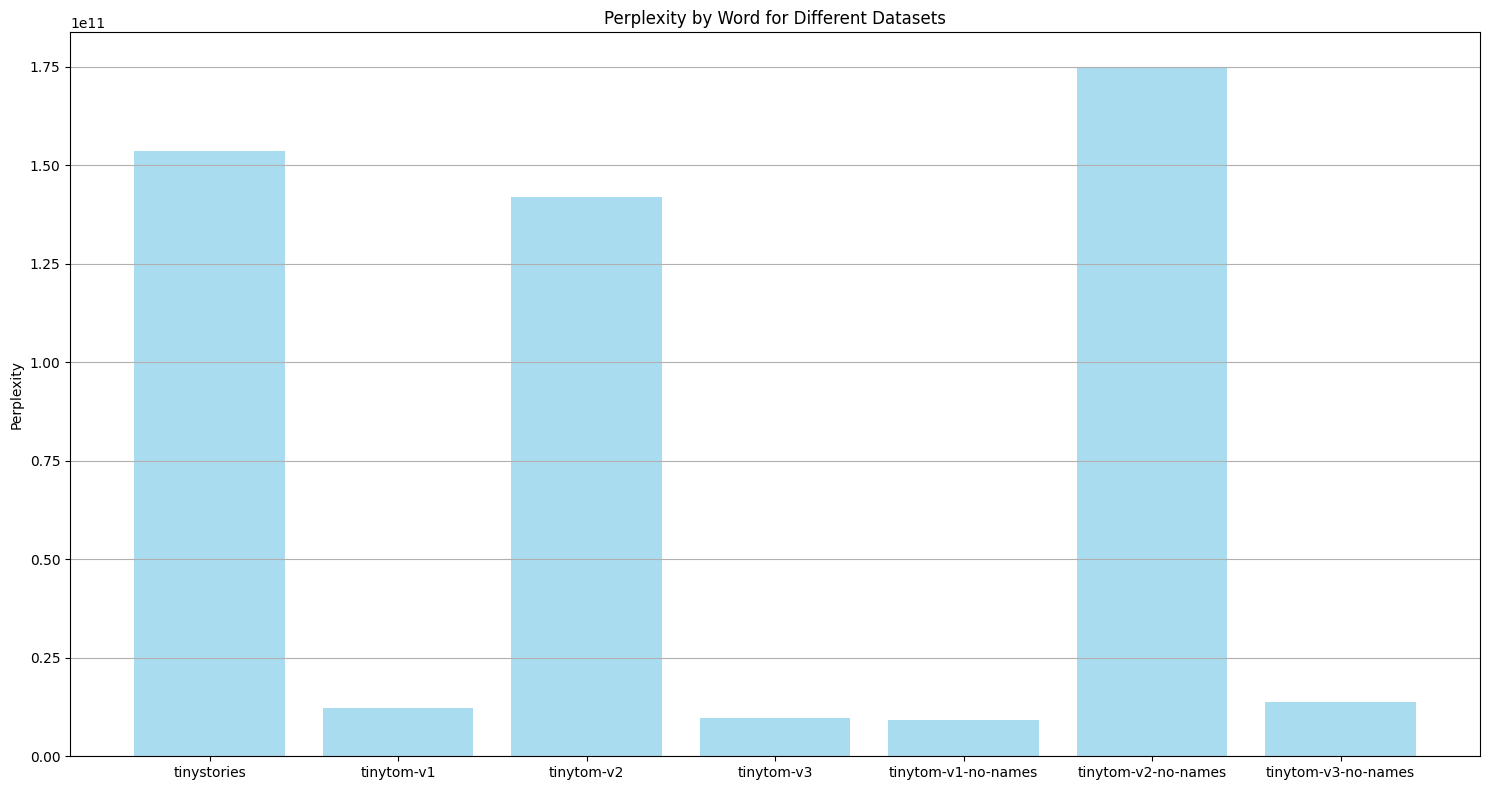

In [86]:
print("Perplexity TinyStories words:", ppl_tinystories[1])
print("Perplexity tinytom-v1 words:", ppl_v1[1])
print("Perplexity tinytom-v2 words:", ppl_v2[1])
print("Perplexity tinytom-v3 words:", ppl_v3[1])

names = ['tinystories', 'tinytom-v1', 'tinytom-v2', 'tinytom-v3', 'tinytom-v1-no-names', 'tinytom-v2-no-names', 'tinytom-v3-no-names']
means = [ppl_tinystories[1], ppl_v1[1], ppl_v2[1], ppl_v3[1], ppl_v1_no_names[1], ppl_v2_no_names[1], ppl_v3_no_names[1]]

# Create the bar plot with error bars
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(names, means, align='center', alpha=0.7, ecolor='black', capsize=10, color='skyblue')

ax.set_ylabel('Perplexity')
ax.set_title('Perplexity by Word for Different Datasets')
ax.yaxis.grid(True)

# Save and show the plot
plt.tight_layout()
# plt.savefig('perplexity_plot.png')
plt.show()

## Filter by vocab -- original template

In [121]:
tiny_vocab = set(word_counts_tinystories.keys())

TINYTOM_V3 = '../../data/tinytom/v3/tinytom.csv'
TINYTOM_V3_IN = '../../data/tinytom/v3/tinytom_in_vocab.csv'
TINYTOM_V3_OUT = '../../data/tinytom/v3/tinytom_out_of_vocab.csv'

TINYTOM_V2 = '../../data/tinytom/tinytom.csv'
TINYTOM_V2_OUT = '../../data/tinytom/tinytom_out_of_vocab.csv'
TINYTOM_V2_IN = '../../data/tinytom/tinytom_in_vocab.csv'

def remove_punctuation(s):
    to_remove = "!\"#$%&()*+,./:;<=>?@[\]^_`{|}"+'\u00e2\u20ac\u0153\u2122'
    for c in to_remove:
        if c in s:
            s = s.replace(c, " ")
    return " ".join(s.split())

def is_name_derivative(word):
    for name in names:
        if name in word: return True
    return False

def split_by_vocab(source_file, output_file_in, output_file_out, exclude_names):
    in_ = []
    out_ = []
    print("Exclude names = ", exclude_names)
    with open(source_file, "r") as f:
        entries = list(f.readlines())
        print("Number of entries:", len(entries))
        for entry in entries:
            entry = entry.replace('auto;0\n', "").replace(";", " ").replace("-", " ").replace("\n", "")
            for word in entry.split():
                word = remove_punctuation(word.strip())
                if word == "": continue
                if exclude_names:
                    if (word not in tiny_vocab and word.lower() not in tiny_vocab) and (word not in names and not is_name_derivative(word)):
                        print(word)
                        out_.append(entry)
                        break
                else:
                    if word not in tiny_vocab and word.lower() not in tiny_vocab:
                        print(word)
                        out_.append(entry)
                        break
            if entry not in out_: in_.append(entry)
        print("Number of entries in:", len(in_))
        print("Number of entries out:", len(out_))
        print("Total logged:", len(in_)+len(out_))

    # if exclude_names:
    #     output_file_in = output_file_in.replace(".csv", "_no_names.csv")
    #     output_file_out = output_file_out.replace(".csv", "_no_names.csv")

    with open(output_file_out, "w") as f:
        for entry in out_:
            f.write(entry+'\n')

    with open(output_file_in, "w") as f:
        for entry in in_:
            f.write(entry+'\n')

# split_by_vocab(TINYTOM_V3, TINYTOM_V3_IN, TINYTOM_V3_OUT, True)
# split_by_vocab(TINYTOM_V2, TINYTOM_V2_IN, TINYTOM_V2_OUT, True)


## Filter by vocab -- corrected files

In [119]:
FOLDER_NAMES = ["0_forward_belief_false_belief", "0_forward_belief_true_belief",
                "1_forward_belief_false_belief", "1_forward_belief_true_belief"]

### First, take correct last sentence from gpt4 generated content

In [111]:
filename = "../../data/conditions/tinytom-v3/0_forward_belief_false_belief/corrected.txt"
last_lines = []
with open(filename, "r") as f:
    for corrected in list(f.readlines()):
        last_line = corrected.split(".")[-1]
        last_lines.append(last_line)

print(len(last_lines))
    
for folder in FOLDER_NAMES:
    if folder == "0_forward_belief_false_belief": continue
    new_corrected = []
    filename = f"../../data/conditions/tinytom-v3/{folder}/corrected.txt"
    with open(filename, "r") as f:
        for i, story in enumerate(list(f.readlines())):
            story = ".".join(story.split(".")[:-1]) + "."
            story = "".join([story, last_lines[i]])
            print(story)
            new_corrected.append(story)
    with open(filename, "w") as f:
        for s in new_corrected:
            f.write(s)

50
Once upon a time, in a bright, cheery kitchen, there was a boy named Tim. He was all set to make a yummy lunch. He decided to make a big bowl of squiggly pasta. The pasta box was filled to the top. Suddenly, a little birdie swooshed right into the kitchen, coming from the window that was wide open. Tim does not see the bird. Tim believes the pasta box is

Once upon a time, Fiona and her buddies were at the park. They decided to play a fun game of soccer. They had a ball that was very clean and sparkly. In the big, green field, a little squirrel was scampering quickly, his fluffy tail bouncing behind him. Fiona does not see the squirrel. Fiona believes the ball is

Once upon a time, in a sunny park, Olivia sat on a bench. She had a yummy-smelling bag of fresh bread. She wanted to share it with the ducks. In the bright, sunny park, Olivia was sitting on a bench. Suddenly, a beautiful butterfly, with wings like a rainbow, gently landed right next to her. Olivia does not see the colorfu

In [126]:
tiny_vocab = set(word_counts_tinystories.keys())

for folder_name in FOLDER_NAMES:
    source_file = f'../../data/conditions/tinytom-v3/{folder_name}/corrected.txt'
    output_file_in = f'../../data/conditions/tinytom-v3/{folder_name}/corrected_in.txt'
    output_file_out = f'../../data/conditions/tinytom-v3/{folder_name}/corrected_out.txt'
    split_by_vocab(source_file, output_file_in, output_file_out, True)
    


Exclude names =  True
Number of entries: 74
squiggly
frolicked
cheeky
girlfriend
roller
cheeky
playfully
deflate
returns
ripples
flipping
cheeky
gnawing
snoozed
bustling
crackling
rearranging
playthings
sketching
drippy
melty
flowed
cheeky
crinkly
treetop
melty
locket
bustling
brim
deposits
slobbery
taker
playfully
pegs
snout
doodling
Number of entries in: 38
Number of entries out: 36
Total logged: 74
Exclude names =  True
Number of entries: 74
squiggly
frolicked
cheeky
girlfriend
roller
cheeky
playfully
deflate
returns
ripples
notices
cheeky
notices
gnawing
snoozed
bustling
crackling
rearranging
playthings
sketching
drippy
melty
flowed
cheeky
crinkly
treetop
melty
locket
bustling
brim
deposits
slobbery
taker
playfully
pegs
snout
doodling
Number of entries in: 37
Number of entries out: 37
Total logged: 74
Exclude names =  True
Number of entries: 74
squiggly
frolicked
cheeky
girlfriend
roller
cheeky
playfully
deflate
returns
ripples
flipping
cheeky
gnawing
neutral
snoozed
bustling
uprig

In [127]:
print("Abby" in names)

True
